In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import xgboost as xgb


from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput import MultiOutputRegressor, RegressorChain

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

from scipy.stats import ttest_1samp
from scipy import stats
from statsmodels.stats import weightstats as stests

from functools import wraps
import time

In [4]:
%run CoreFunction.ipynb

In [5]:
n_comp = 0.95
TEST_SIZE=0.15

In [6]:
scaler_min_max = MinMaxScaler()
scaler_z_score = StandardScaler()

In [7]:
df_data = pd.read_csv(r"output_data_sets/df_data_before_tsa.csv", sep=',')

In [5]:
# def get_feature_importance_data(df, col_name):
#     data = df.copy()
#     y = data[col_name]
#     data = data.drop(col_name, axis=1)
#     X = data.iloc[:, 1:]
#     X = (X - X.min ()) / (X.max () - X.min ())
   
#     train_samples = int(X.shape[0] * (1-TEST_SIZE ))
 
#     X_train = X.iloc[:train_samples]
#     X_test = X.iloc[train_samples:]

#     y_train = y.iloc[:train_samples]
#     y_test = y.iloc[train_samples:]
    
#     return (X_train, y_train), (X_test, y_test)

In [8]:
df_data

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,weather_main_drizzle_Valencia,weather_main_dust_Valencia,weather_main_fog_Valencia,weather_main_haze_Valencia,weather_main_mist_Valencia,weather_main_rain_Valencia,weather_main_smoke_Valencia,weather_main_snow_Valencia,weather_main_squall_Valencia,weather_main_thunderstorm_Valencia
0,2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,0,0,0,0,0,0,0,0,0,0
1,2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,0,0,0,0,0,0,0,0,0,0
2,2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0,0,0,0,0,0,0,0,0,0
3,2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0,0,0,0,0,0,0,0,0,0
4,2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,...,0,0,0,0,0,0,0,0,0,0
35060,2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,...,0,0,0,0,0,0,0,0,0,0
35061,2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,...,0,0,0,0,0,0,0,0,0,0
35062,2018-12-31 21:00:00+00:00,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,...,0,0,0,0,0,0,0,0,0,0


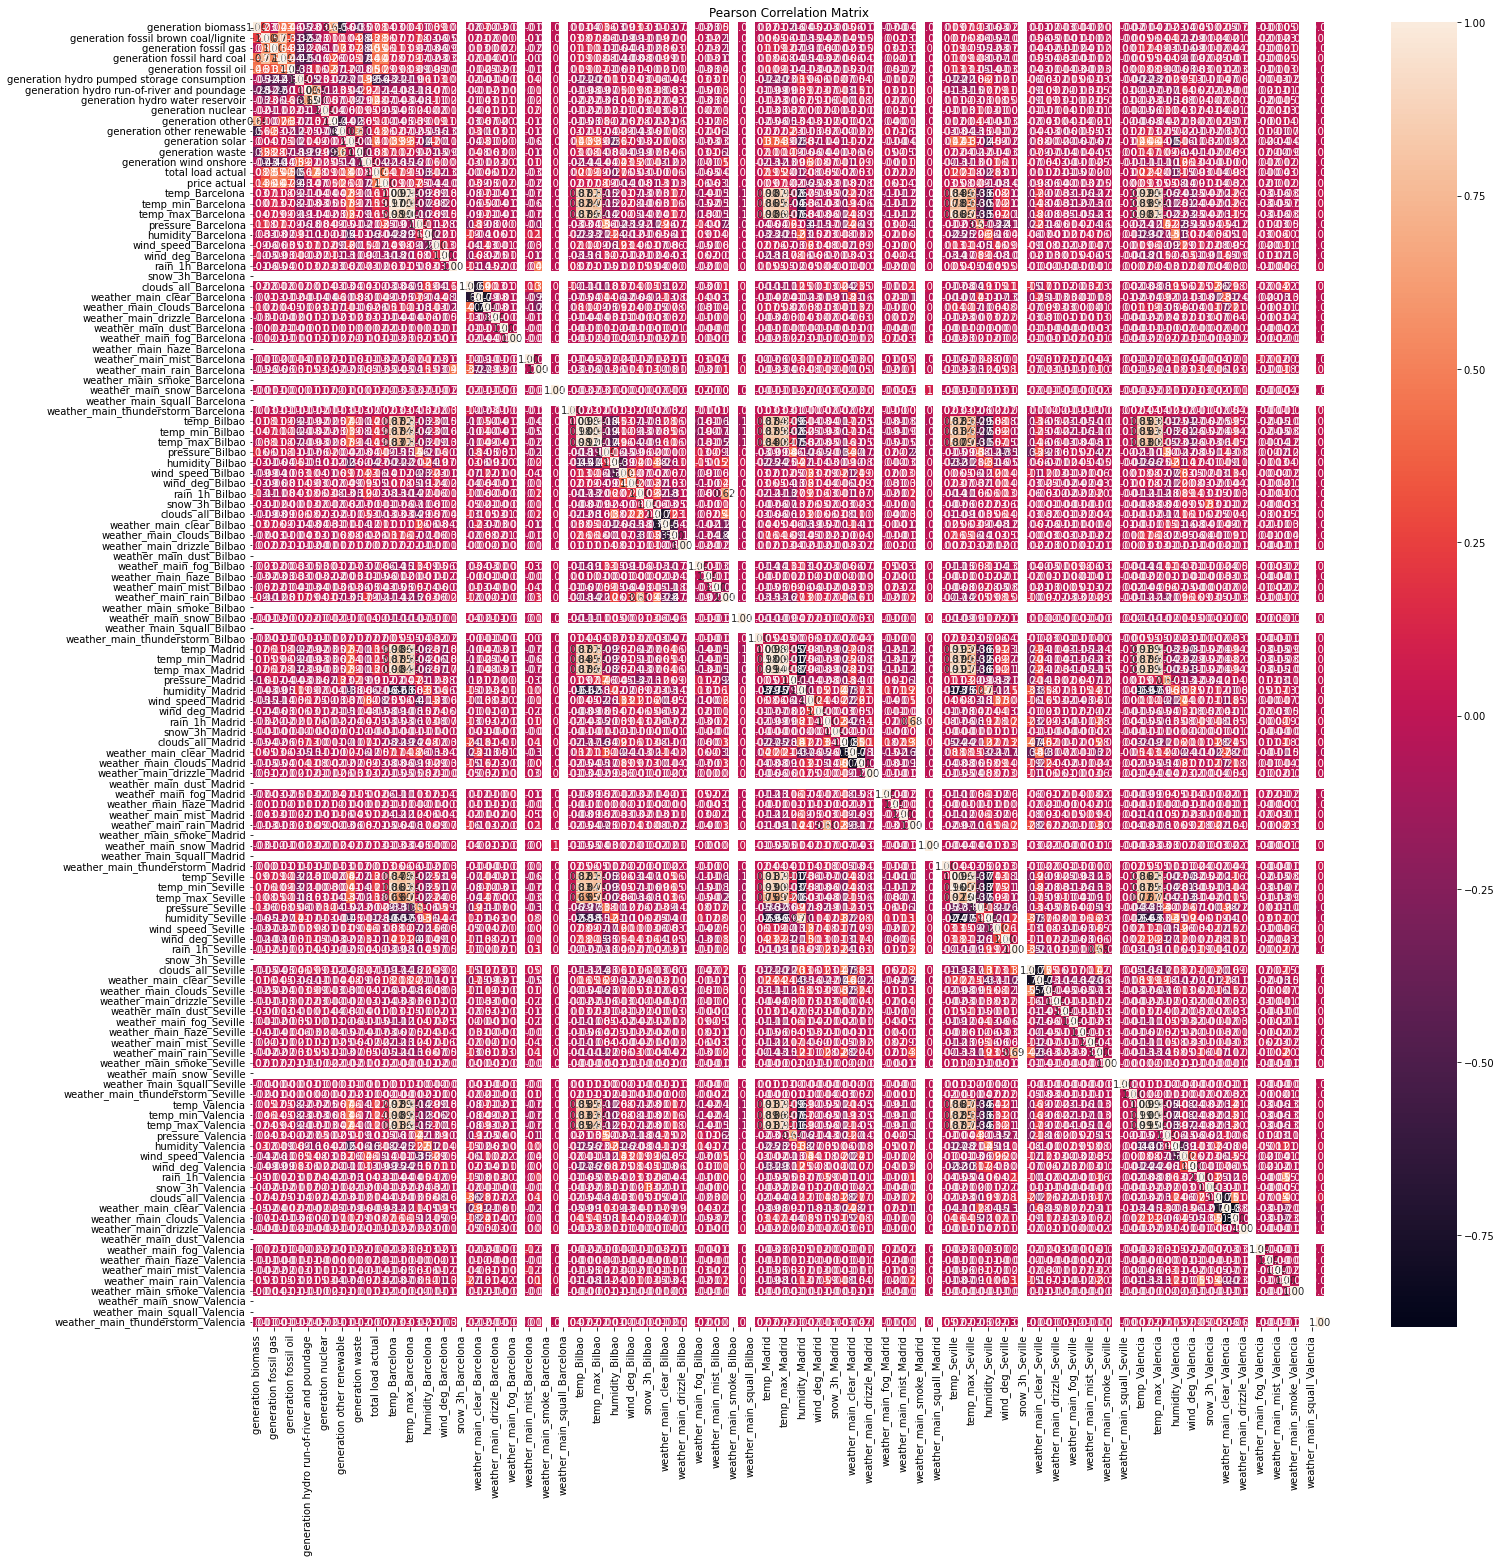

In [9]:
correlations = df_data.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [10]:
print(correlations['price actual'].sort_values(ascending=False).to_string())

price actual                                   1.000000
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.246969
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
weather_main_clear_Bilbao                      0.106470
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0.096279
temp_Valencia                                  0

In [11]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

In [12]:
df_price_final = df_data
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for i in range(len(df_price_final)):
    position = df_price_final.index[i]
    for city in cities:
        temp_max = df_price_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_price_final.loc[position, 'temp_min_{}'.format(city)]
        df_price_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)
df_price_final['generation coal all'] = df_data['generation fossil hard coal'] + df_data['generation fossil brown coal/lignite']

In [13]:
for city in cities:
    df_price_final = df_price_final.drop([ f'temp_max_{city}', f'temp_min_{city}'], axis = 1)
df_price_final = df_price_final.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1)

In [14]:
correlations = df_price_final.corr(method='pearson')
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

temp_Barcelona    temp_Bilbao         0.866727
                  temp_Madrid         0.903996
                  temp_Seville        0.841910
                  temp_Valencia       0.917506
temp_Bilbao       temp_Barcelona      0.866727
                  temp_Madrid         0.872668
                  temp_Seville        0.821292
                  temp_Valencia       0.853744
temp_Madrid       temp_Barcelona      0.903996
                  temp_Bilbao         0.872668
                  temp_Seville        0.909421
                  temp_Valencia       0.912281
humidity_Madrid   humidity_Seville    0.772896
temp_Seville      temp_Barcelona      0.841910
                  temp_Bilbao         0.821292
                  temp_Madrid         0.909421
                  temp_Valencia       0.860792
humidity_Seville  humidity_Madrid     0.772896
temp_Valencia     temp_Barcelona      0.917506
                  temp_Bilbao         0.853744
                  temp_Madrid         0.912281
             

In [15]:
df_price_final["temp_mean"] = (df_price_final['temp_Barcelona']+df_price_final['temp_Valencia']+df_price_final['temp_Bilbao']+df_price_final['temp_Madrid']+df_price_final['temp_Seville'])/5

In [16]:
df_price_final = df_price_final.drop(['temp_Barcelona', 'temp_Valencia', 'temp_Bilbao','temp_Madrid','temp_Seville'], axis = 1)
df_price_final

,time,generation biomass,generation fossil gas,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,...,weather_main_snow_Valencia,weather_main_squall_Valencia,weather_main_thunderstorm_Valencia,temp_range_Barcelona,temp_range_Bilbao,temp_range_Madrid,temp_range_Seville,temp_range_Valencia,generation coal all,temp_mean
0,2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,5150.0,272.491463
1,2015-01-01 00:00:00+00:00,449.0,5196.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,5083.0,272.512700
2,2015-01-01 01:00:00+00:00,448.0,4857.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,4904.0,272.099137
3,2015-01-01 02:00:00+00:00,438.0,4314.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,4385.0,272.089469
4,2015-01-01 03:00:00+00:00,428.0,4130.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,4027.0,272.145900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 18:00:00+00:00,297.0,7634.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,95.0,...,0,0,0,4.0,2.0,3.0,1.0,1.0,2628.0,284.470000
35060,2018-12-31 19:00:00+00:00,296.0,7241.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,95.0,...,0,0,0,3.0,3.0,3.0,1.0,2.0,2566.0,282.294000
35061,2018-12-31 20:00:00+00:00,292.0,7025.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,94.0,...,0,0,0,4.0,0.0,0.0,0.0,1.0,2422.0,280.850000
35062,2018-12-31 21:00:00+00:00,293.0,6562.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,93.0,...,0,0,0,6.0,1.0,1.0,0.0,2.0,2293.0,279.718000


In [17]:
correlations = df_price_final.corr(method='pearson')
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

humidity_Madrid   humidity_Seville    0.772896
humidity_Seville  humidity_Madrid     0.772896


In [18]:
# df_price_final.to_csv(r'output_data_sets/df_prices_mif_final-withoutPCA.csv', index = False, header=True)

In [19]:
# df_data = pd.read_csv(r"output_data_sets/df_prices_mif_final-withoutPCA.csv", sep=',')

In [20]:
# df_data.columns.to_list()

In [21]:
df_data = pd.read_csv(r'output_data_sets/df_prices_mif_final-withoutPCA.csv', sep=',') 
target = df_data["price actual"]       
attribute = df_data.drop(["time", "price actual"], axis = 1)

In [24]:
price_atribute_train, price_atribute_test, price_target_train, price_target_test, price_attribute_col_names = scaled_data(target, attribute, TEST_SIZE, scaler_z_score)

In [25]:
price_atribute_train.shape, price_target_train.shape, price_atribute_test.shape, price_target_test.shape

((29804, 115), (29804,), (5260, 115), (5260,))

Тестваме с времеви редове 720 наблюдения назад, отместване 24 наблюдения и вземаме 24 Targets

In [26]:
WINDOW_SIZE = 24*30
TARGET_LEN = 24*1
DELAY = 24*1

In [27]:
def prepare_windows(df, window_size, col_name, target_count, delay):
    r=len(df)
    ts_dataset = pd.DataFrame()
    ts_dataset_t = pd.DataFrame()
    for i in range(0, window_size):
        ts_dataset[f"Lag_{i+1}"] = df[col_name].shift(i) 
    for j in range(window_size, window_size+target_count):
        ts_dataset_t[f"Target_{j-window_size+1}"] = df[col_name].shift(window_size-j-delay) 
    ts_dataset_out =  pd.concat([df, ts_dataset, ts_dataset_t], axis=1)
    return ts_dataset_out.loc[window_size-1:r-target_count-delay, :] 

In [29]:
COLUMN_NAME = 'price actual'
df_data_price_ts = prepare_windows(df_data, WINDOW_SIZE, COLUMN_NAME, TARGET_LEN, 0) 

<ipython-input-27-c79e9902314a>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ts_dataset[f"Lag_{i+1}"] = df[col_name].shift(i)


In [30]:
df_data = df_data_price_ts
target_cols = [col for col in df_data.columns if 'Target' in col]
target = df_data[target_cols]       
attribute = df_data.drop(["time", "price actual"], axis = 1)
attribute = attribute.drop(target_cols, axis = 1)

In [34]:
target.columns.to_list()

['Target_1',
 'Target_2',
 'Target_3',
 'Target_4',
 'Target_5',
 'Target_6',
 'Target_7',
 'Target_8',
 'Target_9',
 'Target_10',
 'Target_11',
 'Target_12',
 'Target_13',
 'Target_14',
 'Target_15',
 'Target_16',
 'Target_17',
 'Target_18',
 'Target_19',
 'Target_20',
 'Target_21',
 'Target_22',
 'Target_23',
 'Target_24']

In [35]:
price_atribute_train, price_atribute_test, price_target_train, price_target_test, price_attribute_col_names = scaled_data(target, attribute, TEST_SIZE, scaler_z_score)

Тестваме няколко базови модела. 
### Linear Regression

In [36]:
price_linear_regression = LinearRegression().fit(price_atribute_train, price_target_train)

In [40]:
price_lr_mse_train, price_lr_mae_train, price_lr_r2_train = evaluation_report(price_linear_regression, price_atribute_train, price_target_train)

Score Results:
Mean squared error: 25.28
Root mean squared error: 4.82
Mean absolute error: 3.56
Coefficient of determination: 0.8739
Predicted mean: 57.721 (13.239)


In [41]:
price_lr_mse_test, price_lr_mae_test, price_lr_r2_test = evaluation_report(price_linear_regression, price_atribute_test, price_target_test)

Score Results:
Mean squared error: 27.11
Root mean squared error: 4.99
Mean absolute error: 3.65
Coefficient of determination: 0.8625
Predicted mean: 57.760 (13.094)


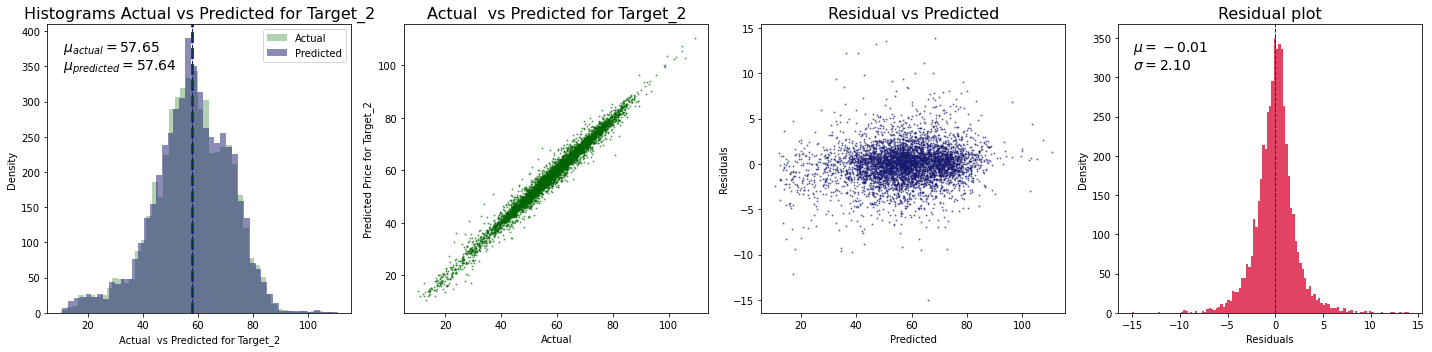

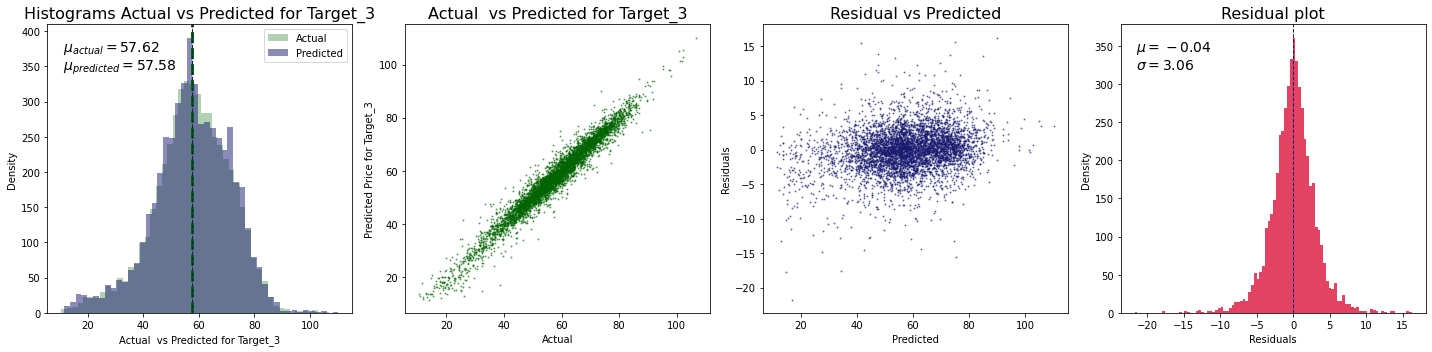

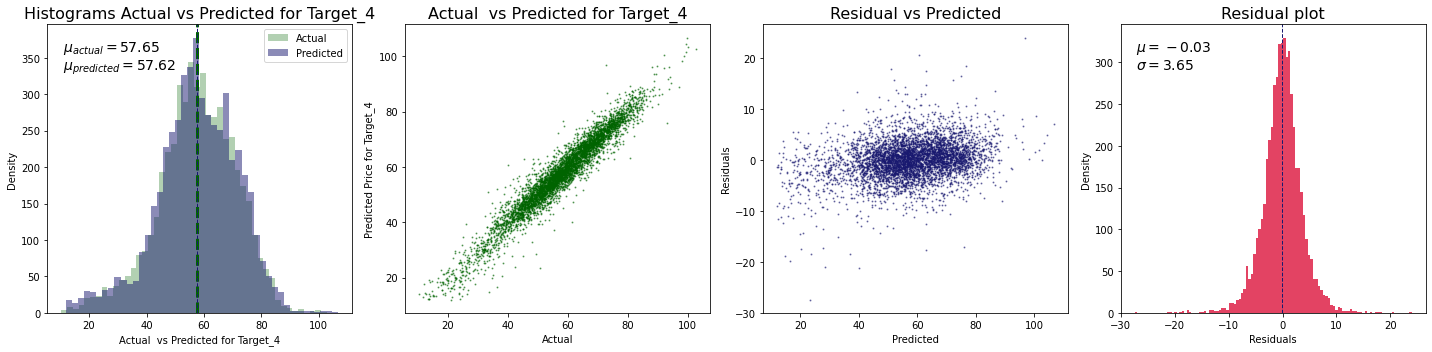

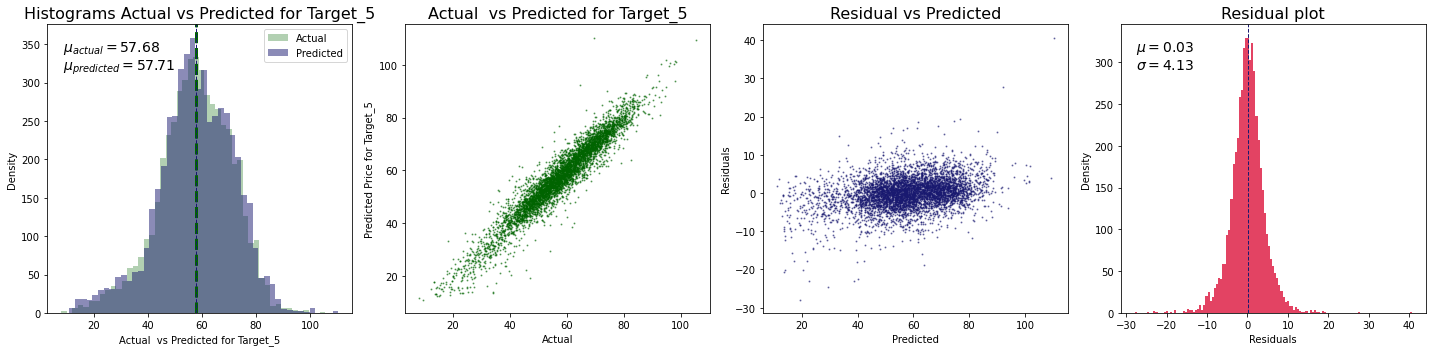

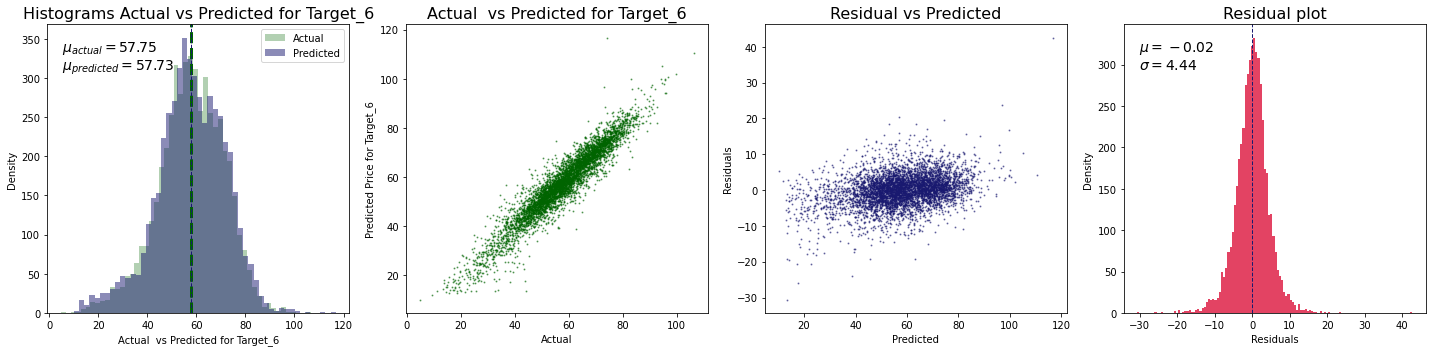

In [47]:
price_prediction = price_linear_regression.predict(price_atribute_test)
price_e_minus_o = get_and_plot_data(price_prediction, price_target_test, start_index=1, stop_index=6)

In [48]:
price_e_minus_o

,Actual,Predicted_Target_6,Predicted-Actual
0,61.636265,62.83,1.193735
1,49.686363,53.70,4.013637
2,70.001582,71.96,1.958418
3,65.702963,64.93,-0.772963
4,48.367489,40.84,-7.527489
...,...,...,...
5144,55.061488,54.17,-0.891488
5145,17.138657,14.14,-2.998657
5146,55.135134,54.40,-0.735134
5147,58.138632,59.00,0.861368


### Ridge Regression

In [161]:
ridge = Ridge()

In [162]:
tuned_params = {
    "alpha": [1000, 2000, 2500, 3000] #tested with [0.001, 0.01, 1, 10, 100, 1000, 10000, 100000],
}
cv = 3
price_ridge = get_grid_search(ridge, tuned_params, cv, price_atribute_train, price_target_train )

Ridge(alpha=1000)
Function took 5.6941 seconds


In [163]:
_, _, _ = evaluation_report(price_ridge, price_atribute_train, price_target_train)

Score Results:
Mean squared error: 25.90
Root mean squared error: 4.94
Mean absolute error: 3.64
Coefficient of determination: 0.8708
Predicted mean: 57.721 (13.114)


In [164]:
_, _, _ = evaluation_report(price_ridge, price_atribute_test, price_target_test)

Score Results:
Mean squared error: 26.79
Root mean squared error: 5.02
Mean absolute error: 3.68
Coefficient of determination: 0.8641
Predicted mean: 57.758 (12.968)


### LASSO Regression

In [116]:
lasso = Lasso(tol=0.001, max_iter=1000)

In [117]:
tuned_params = {
    "alpha": [0.001, 0.01 , 0.1] #tested with [0.001,0.005, 0.01, 1, 5, 10, 100, 1000, 10000, 100000]
}
cv = 3

price_lasso = get_grid_search(lasso, tuned_params, cv, price_atribute_train, price_target_train )

Lasso(alpha=0.1, tol=0.001)
Function took 10.2854 seconds


In [118]:
_, _, _ = evaluation_report(price_lasso, price_atribute_train, price_target_train)

Score Results:
Mean squared error: 0.01
Root mean squared error: 0.10
Mean absolute error: 0.08
Coefficient of determination: 0.9999
Predicted mean: 57.739 (14.013)


In [119]:
_, _, _ = evaluation_report(price_lasso, price_atribute_test, price_target_test)

Score Results:
Mean squared error: 0.01
Root mean squared error: 0.10
Mean absolute error: 0.08
Coefficient of determination: 0.9999
Predicted mean: 57.810 (14.021)


### DecisionTree Regression

In [121]:
price_decision_tree_regression = DecisionTreeRegressor().fit(price_atribute_train, price_target_train)

In [122]:
_, _, _ = evaluation_report(price_decision_tree_regression, price_atribute_train, price_target_train)

Score Results:
Mean squared error: 0.00
Root mean squared error: 0.00
Mean absolute error: 0.00
Coefficient of determination: 1.0000
Predicted mean: 57.739 (14.113)


In [123]:
_, _, _ = evaluation_report(price_decision_tree_regression, price_atribute_test, price_target_test)

Score Results:
Mean squared error: 0.00
Root mean squared error: 0.03
Mean absolute error: 0.01
Coefficient of determination: 1.0000
Predicted mean: 57.809 (14.121)


In [88]:
decision_tree =  DecisionTreeRegressor()
tuned_params = {
    "max_depth": [5, 10, 15, 20, ],
    "max_leaf_nodes": [20, 50, 80, 100],
}

cv = 3
price_decision_tree_regression = get_grid_search(decision_tree, tuned_params, cv, price_atribute_train, price_target_train )

DecisionTreeRegressor(max_depth=20, max_leaf_nodes=100)
Function took 120.7698 seconds


In [89]:
_, _, _ = evaluation_report(price_decision_tree_regression, price_atribute_train, price_target_train)

Score Results:
Mean squared error: 0.06
Root mean squared error: 0.24
Mean absolute error: 0.19
Coefficient of determination: 0.9997
Predicted mean: 57.685 (14.136)


In [90]:
_, _, _ = evaluation_report(price_decision_tree_regression, price_atribute_test, price_target_test)

Score Results:
Mean squared error: 0.07
Root mean squared error: 0.26
Mean absolute error: 0.19
Coefficient of determination: 0.9997
Predicted mean: 57.868 (14.227)


### Linear SVR

In [49]:
def evaluate_svr(att, target, c, model_wrapper):
    svr = LinearSVR(epsilon=0.0, C=c, max_iter = 1000, tol = 0.001, random_state=42,  loss='squared_epsilon_insensitive', dual=False)
    if model_wrapper == "MultiOutputRegressor":
        svr_wrapped = MultiOutputRegressor(svr)
    elif model_wrapper == "RegressorChain":
        svr_wrapped = RegressorChain(svr)
    else: 
        return
    svr_wrapped.fit(att, target)            
    return svr_wrapped

In [50]:
@timeit
def get_model_results(PC_train, price_target_train, PC_test, price_target_test, c, model_wrapper):
    results = pd.DataFrame(columns=['C', 'mse_train', 'mae_train', 'rmse_train', 'r2_train', 'mse_test', 'mae_test', 'rmse_test', 'r2_test'])
    for i in range (0,len(c)):
        linear_SVR = evaluate_svr(PC_train, price_target_train, c[i], model_wrapper)
        mse, mae, rmse, r2 = evaluation_results(linear_SVR, PC_train, price_target_train)
        mse_test, mae_test, rmse_test, r2_test = evaluation_results(linear_SVR, PC_test, price_target_test)
        df = pd.DataFrame()
        df = {'C':c[i] , 'mse_train':mse, 'mae_train':mae, 'rmse_train':rmse, 'r2_train':r2, 'mse_test':mse_test, 'mae_test':mae_test, 'rmse_test':rmse_test, 'r2_test':r2_test}
        results = results.append(df, ignore_index = True)
    results = results.set_index('C')
    return results

In [180]:
c = [0.0001, 0.0005, 0.001, 0.01,  0.1, 1, 10, 100, 1000,] 
res_rc_svr = get_model_results(price_atribute_train, price_target_train, price_atribute_test, price_target_test, c, "MultiOutputRegressor")
res_rc_svr


Function took 938.5148 seconds


,mse_train,mae_train,rmse_train,r2_train,mse_test,mae_test,rmse_test,r2_test
C,,,,,,,,
0.0001,99.217817,8.904704,9.949381,0.505222,99.922359,8.938163,9.984940,0.493270
0.0005,29.610133,4.109429,5.333591,0.852306,30.274960,4.130159,5.391577,0.846453
0.0010,26.631391,3.764526,5.012395,0.867158,27.421523,3.794269,5.084316,0.860921
0.0100,25.437079,3.583722,4.849803,0.873113,26.507275,3.630315,4.949450,0.865556
0.1000,25.406869,3.576530,4.844682,0.873263,26.549278,3.627468,4.951180,0.865342
1.0000,25.402008,3.576126,4.844239,0.873288,26.563227,3.627968,4.952525,0.865271
10.0000,25.399896,3.575260,4.843317,0.873298,26.564300,3.627264,4.951882,0.865266
100.0000,25.405237,3.576142,4.844531,0.873272,26.553808,3.627373,4.951675,0.865319
1000.0000,25.401354,3.575881,4.844158,0.873291,26.561676,3.627757,4.952299,0.865279


In [185]:
c = [0.0005, 0.001, 0.01,  0.1, 1, 10, 100, 1000] 
res_rc1_svr = get_model_results(price_atribute_train, price_target_train, price_atribute_test, price_target_test, c, "RegressorChain")
res_rc1_svr

Function took 311.9997 seconds


,mse_train,mae_train,rmse_train,r2_train,mse_test,mae_test,rmse_test,r2_test
C,,,,,,,,
0.0005,46.084603,5.065236,6.629710,0.770131,45.800215,5.031143,6.609269,0.767721
0.0010,43.839054,4.829645,6.419123,0.781326,43.535151,4.794077,6.396165,0.779206
0.0100,43.666848,4.744809,6.358678,0.782181,43.378206,4.708318,6.336127,0.780002
0.1000,43.849130,4.751779,6.369710,0.781272,43.569340,4.715474,6.347685,0.779032
1.0000,43.871365,4.752751,6.371279,0.781161,43.593661,4.716512,6.349376,0.778909
10.0000,43.990120,4.759784,6.379499,0.780569,43.709722,4.723593,6.357465,0.778319
100.0000,43.873615,4.752934,6.371449,0.781150,43.594137,4.716667,6.349422,0.778907
1000.0000,43.874620,4.752915,6.371505,0.781145,43.596567,4.716691,6.349578,0.778894
